In [1]:
from ours_eval import csls_knn_10_score, evaluation
# from ours_eval import csls_knn_10_score
import numpy as np
import utils
import params

In [2]:
src_id2word, src_word2id, src_embeddings = utils.read_txt_embeddings('data/wiki.%s.vec' % params.src_lang, params.n_eval_ex, False) #n_eval_ex = 200000
tgt_id2word, tgt_word2id, tgt_embeddings = utils.read_txt_embeddings('data/wiki.%s.vec' % params.tgt_lang, params.n_eval_ex, False)

Loaded 200000 pre-trained word embeddings.
Loaded 200000 pre-trained word embeddings.


In [3]:
cross_dict_src2tgt = utils.load_dictionary('data/%s-%s.5000-6500.txt' % (params.src_lang, params.tgt_lang), src_word2id, tgt_word2id)
cross_dict_tgt2src = utils.load_dictionary('data/%s-%s.5000-6500.txt' % (params.tgt_lang, params.src_lang), tgt_word2id, src_word2id)

data/en-es.5000-6500.txt
Found 2975 pairs of words in the dictionary (1500 unique). 0 other pairs contained at least one unknown word (0 in lang1, 0 in lang2)
data/es-en.5000-6500.txt
Found 2416 pairs of words in the dictionary (1500 unique). 0 other pairs contained at least one unknown word (0 in lang1, 0 in lang2)


In [10]:
T = np.load("%s/%s_%s_T.npy" % (params.cp_dir, params.src_lang, params.tgt_lang))
TranslatedX = src_embeddings.dot(np.transpose(T))

In [17]:
import faiss
def get_nn_avg_dist(emb, query, knn):
    # gpu mode
    res = faiss.StandardGpuResources()  # use a single GPU
    index = faiss.IndexFlatIP(emb.shape[1])
    index = faiss.index_cpu_to_gpu(res, 0, index)
    index.add(emb)
    distances, _ = index.search(query, knn)
    return distances.mean(1)

In [19]:
# refe
emb_trans=TranslatedX
emb_tgt=tgt_embeddings
dico=cross_dict_src2tgt
emb_trans = emb_trans / np.linalg.norm(emb_trans, ord=2, axis=1, keepdims=True)
emb_tgt = emb_tgt / np.linalg.norm(emb_tgt, ord=2, axis=1, keepdims=True)
emb_trans = emb_trans.astype('float32')
emb_tgt = emb_tgt.astype('float32')
# I use csls_knn_10 directly
average_dist1 = get_nn_avg_dist(emb = emb_tgt, query = emb_trans, knn = 10) #(200000,)
average_dist2 = get_nn_avg_dist(emb = emb_trans, query = emb_tgt, knn = 10) #(200000,)
average_dist1.shape

(200000,)

In [14]:
# from utils import get_nn_avg_dist
def csls_knn_10_score(emb_trans, emb_tgt, dico):
    emb_trans = emb_trans / np.linalg.norm(emb_trans, ord=2, axis=1, keepdims=True)
    emb_tgt = emb_tgt / np.linalg.norm(emb_tgt, ord=2, axis=1, keepdims=True)
    emb_trans = emb_trans.astype('float32')
    emb_tgt = emb_tgt.astype('float32')
    # I use csls_knn_10 directly
    average_dist1 = get_nn_avg_dist(emb = emb_tgt, query = emb_trans, knn = 10) #(200000,)
    average_dist2 = get_nn_avg_dist(emb = emb_trans, query = emb_tgt, knn = 10) #(200000,)
    
    query = emb_trans[dico[:, 0]] # dico[:, 0] is from source Domain, # dico[:, 1] is from target domain
    scores = 2 * query.dot(emb_tgt.T) #2975*200000
    scores -= average_dist1[dico[:, 0]][:, None] # right hand side: 2975, 1
    scores -= average_dist2[None,:] # right hand side: 1, 200000
    
    return scores
scores = csls_knn_10_score(emb_trans=TranslatedX, emb_tgt=tgt_embeddings, dico=cross_dict_src2tgt)
evaluation(scores, cross_dict_src2tgt)

In [15]:
evaluation(scores, cross_dict_src2tgt)

1500 source words -   - Precision at k = 1: 81.200000
1500 source words -   - Precision at k = 5: 90.600000
1500 source words -   - Precision at k = 10: 92.400000


[('precision_at_1', 81.2),
 ('precision_at_5', 90.60000000000001),
 ('precision_at_10', 92.4)]

In [8]:
# from utils import get_nn_avg_dist
def csls_knn_10_score_2(emb_trans, emb_tgt, dico):
    emb_trans = emb_trans / np.linalg.norm(emb_trans, ord=2, axis=1, keepdims=True)
    emb_tgt = emb_tgt / np.linalg.norm(emb_tgt, ord=2, axis=1, keepdims=True)
    emb_trans = emb_trans.astype('float32')
    emb_tgt = emb_tgt.astype('float32')
    # I use csls_knn_10 directly
    average_dist1 = get_nn_avg_dist(emb = emb_tgt, query = emb_trans, knn = 10) #(200000,)
    average_dist2 = get_nn_avg_dist(emb = emb_trans, query = emb_tgt, knn = 10) #(200000,)
    average_dist3 = get_nn_avg_dist(emb = emb_trans, query = emb_trans, knn = 10) #(200000,)
    average_dist4 = get_nn_avg_dist(emb = emb_tgt, query = emb_tgt, knn = 10) #(200000,)
    
    query = emb_trans[dico[:, 0]] # dico[:, 0] is from source Domain, # dico[:, 1] is from target domain
    scores = 4 * query.dot(emb_tgt.T) #2975*200000
    scores -= average_dist1[dico[:, 0]][:, None] # right hand side: 2975, 1
    scores -= average_dist2[None,:] # right hand side: 1, 200000
    scores -= average_dist3[dico[:, 0]][:, None]
    scores -= average_dist4[None,:]
    return scores
scores = csls_knn_10_score_2(emb_trans=TranslatedX, emb_tgt=tgt_embeddings, dico=cross_dict_src2tgt)
evaluation(scores, cross_dict_src2tgt)

1500 source words -   - Precision at k = 1: 80.800000
1500 source words -   - Precision at k = 5: 90.333333
1500 source words -   - Precision at k = 10: 92.400000


[('precision_at_1', 80.80000000000001),
 ('precision_at_5', 90.33333333333333),
 ('precision_at_10', 92.4)]

# divide variance when calculating average_dist1

In [18]:
# from utils import get_nn_avg_dist
def csls_knn_10_score_3(emb_trans, emb_tgt, dico):
    emb_trans = emb_trans / np.linalg.norm(emb_trans, ord=2, axis=1, keepdims=True)
    emb_tgt = emb_tgt / np.linalg.norm(emb_tgt, ord=2, axis=1, keepdims=True)
    emb_trans = emb_trans.astype('float32')
    emb_tgt = emb_tgt.astype('float32')
    # I use csls_knn_10 directly
    average_dist1 = get_nn_avg_dist(emb = emb_tgt, query = emb_trans, knn = 10) #(200000,)
    average_dist2 = get_nn_avg_dist(emb = emb_trans, query = emb_tgt, knn = 10) #(200000,)

    query = emb_trans[dico[:, 0]] # dico[:, 0] is from source Domain, # dico[:, 1] is from target domain
    scores = 3 * query.dot(emb_tgt.T) #2975*200000
    scores -= average_dist1[dico[:, 0]][:, None] # right hand side: 2975, 1
    scores -= average_dist2[None,:] # right hand side: 1, 200000

    return scores
scores = csls_knn_10_score_3(emb_trans=TranslatedX, emb_tgt=tgt_embeddings, dico=cross_dict_src2tgt)
evaluation(scores, cross_dict_src2tgt)

1500 source words -   - Precision at k = 1: 79.866667
1500 source words -   - Precision at k = 5: 89.533333
1500 source words -   - Precision at k = 10: 92.066667


[('precision_at_1', 79.86666666666666),
 ('precision_at_5', 89.53333333333333),
 ('precision_at_10', 92.06666666666666)]

In [19]:
# from utils import get_nn_avg_dist
def csls_knn_10_score(emb_trans, emb_tgt, dico):
    emb_trans = emb_trans / np.linalg.norm(emb_trans, ord=2, axis=1, keepdims=True)
    emb_tgt = emb_tgt / np.linalg.norm(emb_tgt, ord=2, axis=1, keepdims=True)
    emb_trans = emb_trans.astype('float32')
    emb_tgt = emb_tgt.astype('float32')
    # I use csls_knn_10 directly
    average_dist1 = get_nn_avg_dist(emb = emb_tgt, query = emb_trans, knn = 10) #(200000,)
    average_dist2 = get_nn_avg_dist(emb = emb_trans, query = emb_tgt, knn = 10) #(200000,)

    query = emb_trans[dico[:, 0]] # dico[:, 0] is from source Domain, # dico[:, 1] is from target domain
    scores = 1 * query.dot(emb_tgt.T) #2975*200000
    scores -= average_dist1[dico[:, 0]][:, None] # right hand side: 2975, 1
    scores -= average_dist2[None,:] # right hand side: 1, 200000

    return scores
scores = csls_knn_10_score(emb_trans=TranslatedX, emb_tgt=tgt_embeddings, dico=cross_dict_src2tgt)
evaluation(scores, cross_dict_src2tgt)

1500 source words -   - Precision at k = 1: 79.600000
1500 source words -   - Precision at k = 5: 89.200000
1500 source words -   - Precision at k = 10: 91.200000


[('precision_at_1', 79.60000000000001),
 ('precision_at_5', 89.2),
 ('precision_at_10', 91.2)]

In [22]:
import faiss
def get_nn_avg_dist_std(emb, query, knn):
    # cpu mode
    res = faiss.StandardGpuResources()  # use a single GPU
    index = faiss.IndexFlatIP(emb.shape[1])
    index = faiss.index_cpu_to_gpu(res, 0, index)
    index.add(emb)
    distances, _ = index.search(query, knn)
    return distances[:,1:].mean(1), distances[:,1:].std(1)

In [23]:
# from utils import get_nn_avg_dist
def csls_knn_10_score(emb_trans, emb_tgt, dico):
    emb_trans = emb_trans / np.linalg.norm(emb_trans, ord=2, axis=1, keepdims=True)
    emb_tgt = emb_tgt / np.linalg.norm(emb_tgt, ord=2, axis=1, keepdims=True)
    emb_trans = emb_trans.astype('float32')
    emb_tgt = emb_tgt.astype('float32')
    # I use csls_knn_10 directly
    average_dist1,average_std1 = get_nn_avg_dist_std(emb = emb_tgt, query = emb_trans, knn = 10) #(200000,)
    average_dist2,average_std2 = get_nn_avg_dist_std(emb = emb_trans, query = emb_tgt, knn = 10) #(200000,)

    query = emb_trans[dico[:, 0]] # dico[:, 0] is from source Domain, # dico[:, 1] is from target domain
    scores1 = query.dot(emb_tgt.T) #2975*200000
    scores2 = scores1.copy()
    scores1 -= average_dist1[dico[:, 0]][:, None] # right hand side: 2975, 1
    scores1 /= average_std1[dico[:, 0]][:, None]
    scores2 -= average_dist2[None,:] # right hand side: 1, 200000
    scores2 /= average_std2[None,:] 
    scores = scores1 + scores2
    return scores
scores = csls_knn_10_score(emb_trans=TranslatedX, emb_tgt=tgt_embeddings, dico=cross_dict_src2tgt)
evaluation(scores, cross_dict_src2tgt)

1500 source words -   - Precision at k = 1: 79.066667
1500 source words -   - Precision at k = 5: 89.733333
1500 source words -   - Precision at k = 10: 92.066667


[('precision_at_1', 79.06666666666666),
 ('precision_at_5', 89.73333333333333),
 ('precision_at_10', 92.06666666666666)]

In [24]:
# from utils import get_nn_avg_dist
def csls_knn_10_score(emb_trans, emb_tgt, dico):
    emb_trans = emb_trans / np.linalg.norm(emb_trans, ord=2, axis=1, keepdims=True)
    emb_tgt = emb_tgt / np.linalg.norm(emb_tgt, ord=2, axis=1, keepdims=True)
    emb_trans = emb_trans.astype('float32')
    emb_tgt = emb_tgt.astype('float32')
    # I use csls_knn_10 directly
    average_dist1,average_std1 = get_nn_avg_dist_std(emb = emb_tgt, query = emb_trans, knn = 10) #(200000,)
    average_dist2,average_std2 = get_nn_avg_dist_std(emb = emb_trans, query = emb_tgt, knn = 10) #(200000,)

    query = emb_trans[dico[:, 0]] # dico[:, 0] is from source Domain, # dico[:, 1] is from target domain
    scores1 = query.dot(emb_tgt.T) #2975*200000
    scores2 = scores1.copy()
    scores1 -= average_dist1[dico[:, 0]][:, None] # right hand side: 2975, 1
#     scores1 /= average_std1[dico[:, 0]][:, None]
    scores2 -= average_dist2[None,:] # right hand side: 1, 200000
#     scores2 /= average_std2[None,:] 
    scores = scores1 + scores2
    return scores
scores = csls_knn_10_score(emb_trans=TranslatedX, emb_tgt=tgt_embeddings, dico=cross_dict_src2tgt)
evaluation(scores, cross_dict_src2tgt)

1500 source words -   - Precision at k = 1: 81.133333
1500 source words -   - Precision at k = 5: 90.533333
1500 source words -   - Precision at k = 10: 92.533333


[('precision_at_1', 81.13333333333334),
 ('precision_at_5', 90.53333333333333),
 ('precision_at_10', 92.53333333333333)]

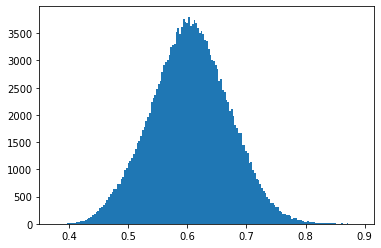

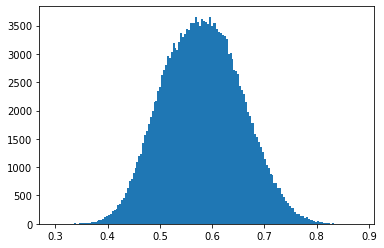

1500 source words -   - Precision at k = 1: 69.933333
1500 source words -   - Precision at k = 5: 83.666667
1500 source words -   - Precision at k = 10: 87.200000


[('precision_at_1', 69.93333333333334),
 ('precision_at_5', 83.66666666666667),
 ('precision_at_10', 87.2)]

In [49]:
import matplotlib.pyplot as plt
def csls_knn_10_score(emb_trans, emb_tgt, dico):
    emb_trans = emb_trans / np.linalg.norm(emb_trans, ord=2, axis=1, keepdims=True)
    emb_tgt = emb_tgt / np.linalg.norm(emb_tgt, ord=2, axis=1, keepdims=True)
    emb_trans = emb_trans.astype('float32')
    emb_tgt = emb_tgt.astype('float32')
    # I use csls_knn_10 directly
    average_dist1,average_std1 = get_nn_avg_dist_std(emb = emb_tgt, query = emb_trans, knn = 10) #(200000,)
    average_dist2,average_std2 = get_nn_avg_dist_std(emb = emb_trans, query = emb_tgt, knn = 10) #(200000,)
    _ = plt.hist(average_dist1, bins='auto')  # arguments are passed to np.histogram
    plt.show()
    _ = plt.hist(average_dist2, bins='auto')  # arguments are passed to np.histogram
    plt.show()
    query = emb_trans[dico[:, 0]] # dico[:, 0] is from source Domain, # dico[:, 1] is from target domain
    scores = 1*query.dot(emb_tgt.T) #2975*200000
    scores -= np.sqrt(average_dist1[dico[:, 0]][:, None])*np.sqrt(average_std2[None,:]) 
    return scores
scores = csls_knn_10_score(emb_trans=TranslatedX, emb_tgt=tgt_embeddings, dico=cross_dict_src2tgt)
evaluation(scores, cross_dict_src2tgt)
# rng = np.random.RandomState(10)  # deterministic random data
# a = np.hstack((rng.normal(size=1000),
#                rng.normal(loc=5, scale=2, size=1000)))
# _ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")

# plt.show()